Karpathy's notebook: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
%matplotlib widget

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [228]:
BLOCK_SIZE = 3

X, Y = [], []
for w in words:
    # print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X= torch.tensor(X)
Y = torch.tensor(Y)

In [229]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [230]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
  
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [6]:
C = torch.randn((27, 2))

In [7]:
X[1,0]

tensor(0)

In [20]:
C[torch.tensor([5,6,7])]

tensor([[ 0.3655, -1.3372],
        [-0.5498, -1.7882],
        [-0.0649,  0.4310]])

In [24]:
emb = C[X]  # this is the embedding vector for each of the character indexes
emb.shape

torch.Size([32, 3, 2])

### Hidden layer

In [25]:
h1_size = 100

W1 = torch.randn((6, h1_size))
b1 = torch.randn(h1_size)


In [41]:
# want emb @ W1 + b1 -- need to reshape emb because it's 32, 3, 2 want 32, 6

# there are different ways to do it
import functools
import operator

In [52]:
%%timeit

emb.reshape((32, 6) )

557 ns ± 5.75 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [47]:
%%timeit
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), dim=1)

8.47 µs ± 42.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [48]:
%%timeit
torch.cat(torch.unbind(emb, 1), dim=1)

3.58 µs ± 90.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [53]:
%%timeit
# storage offsets, strides, and shapes -- Eric pytorch internals
emb.view(32, 6)

544 ns ± 6.89 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [58]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # between -1 and 1 for tanh
h.shape, h.dtype

(torch.Size([32, 100]), torch.float32)

In [60]:
# + b1 broadcasting:
# 32, 100
#  1, 100
#   b1 gets copied 100x, added to each row


In [67]:
W2 = torch.randn((h1_size, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)


In [70]:
prob[torch.arange(32), Y]  # probability the NN gives to the correct character in the sequence

loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(22.9184)

# Model

In [231]:
h_size = 200
embedd_size = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedd_size), generator=g)
W1 = torch.randn((BLOCK_SIZE * embedd_size, h_size), generator=g)
b1 = torch.randn(h_size, generator=g)
W2 = torch.randn((h_size, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters), ' parameters in the model')
for p in parameters:
    p.requires_grad = True

11897  parameters in the model


In [232]:
lre = torch.linspace(-3, 0, 1_000)
lrs = 10**lre

losses = [10]
lres = []
stepi = [-1]


In [273]:
%%time

batch_size = 64


for i in range(1_000_000):
    #minibatching
    #   intuition: better to have approximate gradient and take more steps than have exact gradient and take fewer steps
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, BLOCK_SIZE * embedd_size) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix])


    # why use F.cross_entropy? 1. Don't create intermediate tensors in memory; instead use fused kernels.
    #   2. backward pass can be more efficient (mathematically too since we can compute closed form of the derivative)
    #   3. numerical stability, e.g. when logits take on "extreme" values, we can't store e^100 as a float
    #        pytorch internally calculates the max of the logits and subtracts it from logits (cross_entropy(logits) == cross_entropy(logits+C))


    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    if stepi[-1] < 1e6:
        learning_rate = 1e-1
    if stepi[-1] >= 1e6:
        learning_rate = 5e-2
    if stepi[-1] >= 2e6:
        learning_rate = 1e-2

    #update params
    for p in parameters:
        # p.data += -lrs[i] * p.grad
        p.data += -learning_rate * p.grad
        
    # lres.append(lre[i])
    stepi.append(stepi[-1] + i)
    losses.append(loss.item())


CPU times: user 20min 28s, sys: 3.02 s, total: 20min 31s
Wall time: 3min 25s


Underfitting: training & validation loss are about the same. 
1. increasing hidden layer size doesnt help -- that's not the bottleneck in teh network, maybe it's the hidden layer size

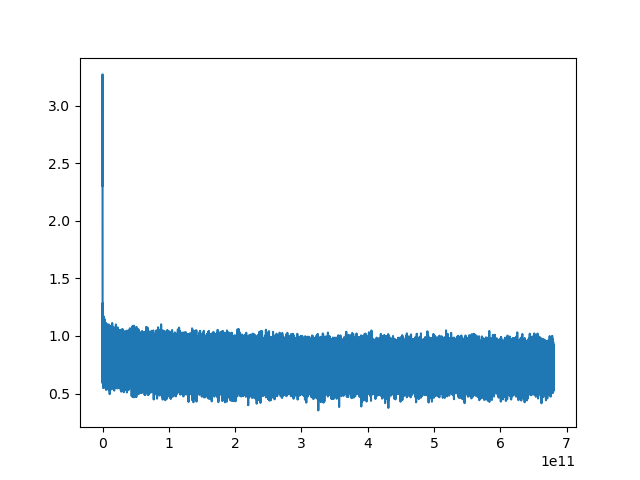

In [274]:
plt.figure()
# "Fat" loss curve becauso of minibatches
#    Low batch size --> noisy gradient
plt.plot(stepi, np.log(losses))


In [275]:
emb = C[X]
h = torch.tanh(emb.view(-1, BLOCK_SIZE * embedd_size) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print('Train loss', loss.item())

Train loss 2.1003878116607666


In [190]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('Dev loss', loss.item())

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('Train loss', loss.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (22781x30 and 50x200)

### Check embeddings


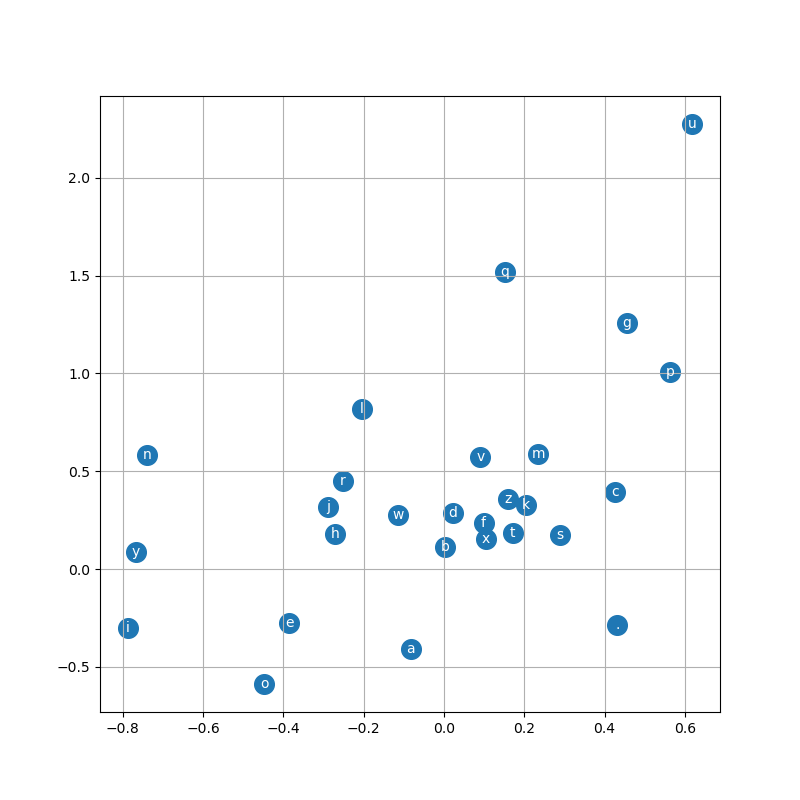

In [107]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### looking for learning rate

1. Identify a learning rate at which the loss goes down reasonably (1e-3 here)
2. Identify a learning rate at which the model clearly diverges (10 here)
3. For each iteration use a different learning rate, record loss with each learning rate
4. Pick learning rate with lowish losses, [-1.3, -0.5] here.

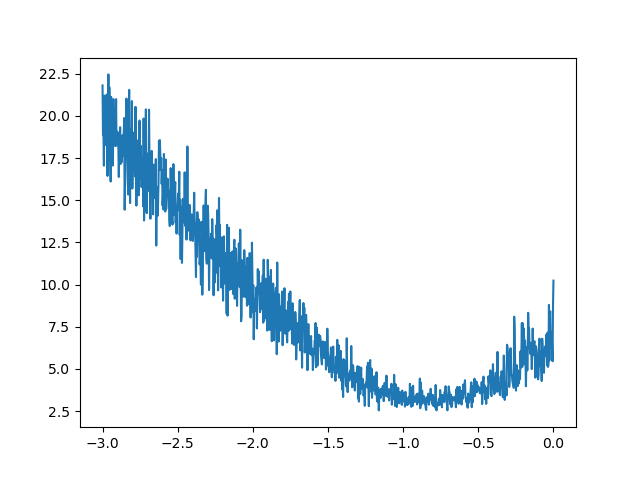

In [34]:
plt.figure()
plt.plot(lres, losses)

There's a lower bound on the amount of error we can get because we have same inputs mapping to different outputs, e.g. ...-> e ...->o ...->m etc

### Learning rate decay
1. Do a few epochs with a LR on the larger end
2. Then reduce the LR

##### Train, Val, Test

### Where to go from here:
1. Tune optimization algorithm
    1. LR
    1. LR decay
    1. Batch size
2. Tune network parameters
3. Tune context window size
4. Other ideas from the paper

In [272]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

prefix = ''
letters_must_contain = 'maksimkerah'
n_letters = 3

suffix_exclude = 'a'
max_length = 8

outputs = set([])

while len(outputs) < 100:
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    if first_character:
        for i, c in enumerate(prefix):
            
            context[block_size-len(prefix)+i] = stoi[c]
            out.append(stoi[c])
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    name = ''.join(itos[i] for i in out)
    if name.endswith(suffix_exclude+'.'):
        continue
    if len(name) - 1 > max_length:
        continue
    
    n_letters_this_name = 0
    for l in set(letters_must_contain):
        if l in name:
            n_letters_this_name += 1
            
    if n_letters_this_name >= n_letters or not letters_must_contain:
        outputs.add(name)
    
print(*sorted(outputs), sep='\n')


aashaan.
abdie.
adrarell.
aire.
alptdere.
amee.
aniah.
arah.
arder.
areian.
arilt.
ario.
arley.
armalyn.
arteez.
ashr.
asur.
aznie.
bariah.
bayren.
braji.
braxydi.
brelesen.
calmoni.
candie.
chriyah.
dearie.
desie.
dhyremer.
eliean.
elliah.
emonilo.
etrayden.
ham.
hayle.
helli.
hohvis.
jakham.
jamaelif.
jamro.
jharyon.
johir.
johnanic.
kactande.
kamar.
kamargan.
kanar.
karin.
kas.
katzion.
kaylee.
khaelah.
kimbayor.
kohithar.
kyri.
lavirdy.
leigh.
leokh.
litayge.
mack.
madell.
madlanen.
maen.
manston.
margon.
mari.
mariah.
mayah.
michan.
milah.
moial.
myane.
nalhas.
nikise.
norah.
osri.
paisi.
prik.
rai.
rhylene.
rick.
riwe.
roice.
rwanderi.
rysenaj.
sam.
sarion.
shan.
shavo.
sheer.
sumuey.
syline.
syreedon.
tricarle.
xeah.
yimarie.
zahiyah.
zakhlie.
zanie.
zararae.
